In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd

In [2]:
cycles = [str(i) for i in range(200,2400,200)]
#cycles = ['200','400', '600']
Auto = pd.DataFrame()
max_rec = 0
max_TS = 0
max_Cyc = 0
file_boundary =[]
for i in cycles:
    Temp = pd.read_csv('./FYP/Data/Full_Test_Data/MOLI_28/MOLI_28_1_'+i+'.csv', skiprows=2)
    Temp.drop(Temp.columns[len(Temp.columns)-1],axis=1,inplace=True)
    Temp.drop('DPt Time', axis=1, inplace=True, errors='ignore')
    Temp.drop('ES', axis=1, inplace=True, errors='ignore')
    Temp['Rec#'] += max_rec
    max_rec = Temp['Rec#'].max()
    Temp['Cyc#'] += max_Cyc
    max_Cyc = Temp['Cyc#'].max()
    print(f"Current max cyc: {max_Cyc}, on file: ...{i}")
    file_boundary.append(max_Cyc)
    Auto = pd.concat([Auto, Temp], axis=0)

Current max cyc: 195, on file: ...200
Current max cyc: 390, on file: ...400
Current max cyc: 595, on file: ...600
Current max cyc: 800, on file: ...800
Current max cyc: 1005, on file: ...1000
Current max cyc: 1210, on file: ...1200
Current max cyc: 1415, on file: ...1400
Current max cyc: 1620, on file: ...1600
Current max cyc: 1825, on file: ...1800
Current max cyc: 2030, on file: ...2000
Current max cyc: 2235, on file: ...2200


print([Auto[i].dtype for i in Auto.columns])
B = Auto['Volts']<3.5
Auto[B].head()

In [3]:
import numpy as np

cleaned = []

for cyc, group in Auto.groupby('Cyc#'):
    group = group.copy()  # avoid SettingWithCopyWarning

    # Normalize columns
    group['Temp 1'] = group['Temp 1'] - group['Temp 1'].iloc[0]
    group['TestTime'] = group['TestTime'] - group['TestTime'].iloc[0]

    # Apply filters
    if group['TestTime'].max() > 16000:
        print(group['TestTime'].max())
        continue

    if ((group['Amps'] > -2) & (group['TestTime'] < 2200)).any():
        continue

    if ((group['Amps'] < 0.1) & (group['TestTime'] > 7000)).any():
        continue

    if ((group['Amps'] > 0.1) & (group['TestTime'] > 2000) & (group['TestTime'] < 5500)).any():
        continue

    if (group['Temp 1'] < -1).any():
        group['Temp 1'] = np.nan
    # --- New check for Temp 1 at TestTime ≈ 2000 ---
    # Find the row closest to 2000
    idx_2000 = (group['TestTime'] - 2000).abs().idxmin()
    temp_at_2000 = group.loc[idx_2000, 'Temp 1']

    if temp_at_2000 < 0.5:
        group['Temp 1'] = np.nan

    cleaned.append(group)

# Combine all good cycles
Auto = pd.concat(cleaned, ignore_index=True)


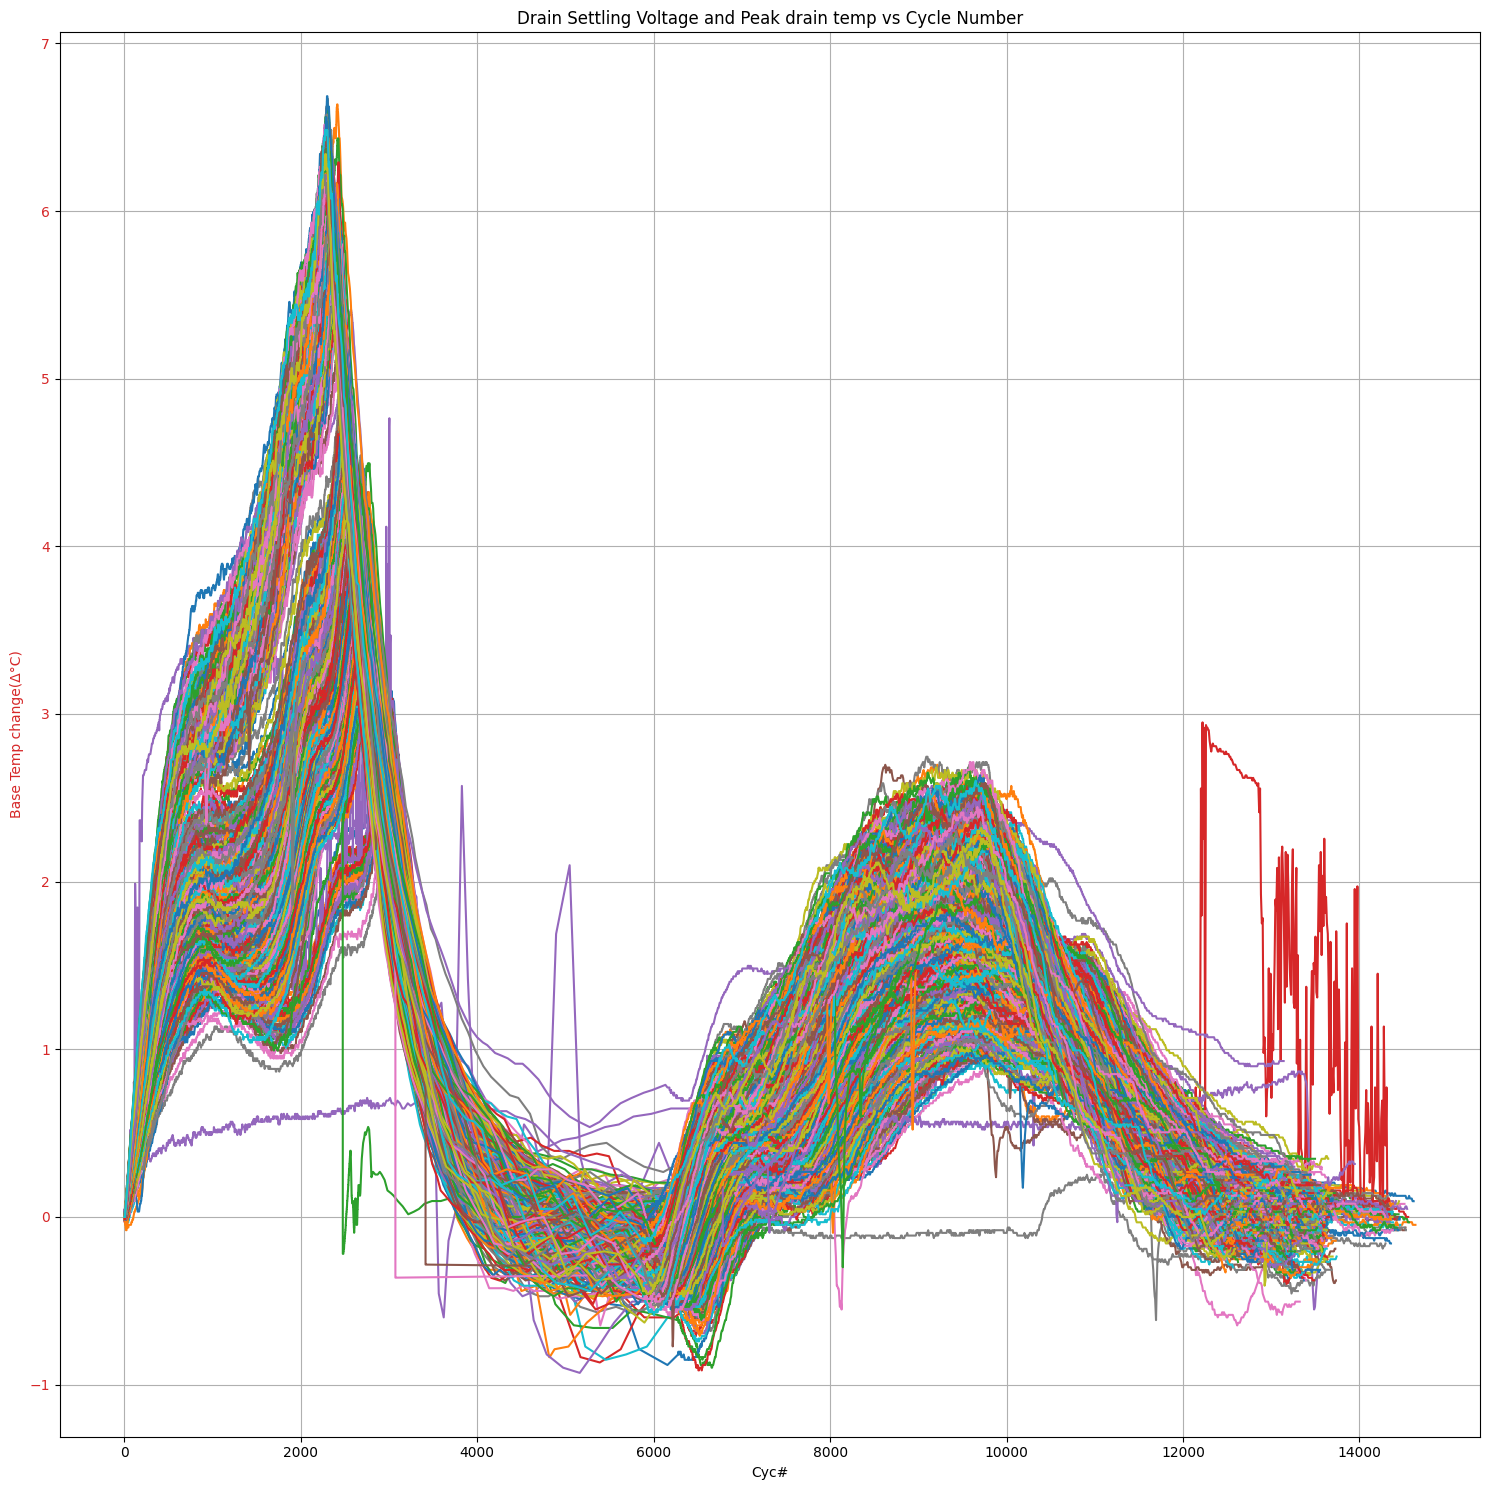

In [4]:
fig, ax = plt.subplots(figsize=(15, 15))
for cyc, group in Auto.groupby('Cyc#'):
    ax.plot(group['TestTime'], group['Temp 1'])
color2 = 'tab:red'
ax.set_ylabel('Base Temp change(Δ°C)', color=color2)
ax.set_xlabel('Cyc#')
ax.tick_params(axis='y', labelcolor=color2)
plt.title('Drain Settling Voltage and Peak drain temp vs Cycle Number')
fig.tight_layout()
plt.grid(True)
plt.show()
fig.savefig("MOLI_28_temp.png", dpi=300)

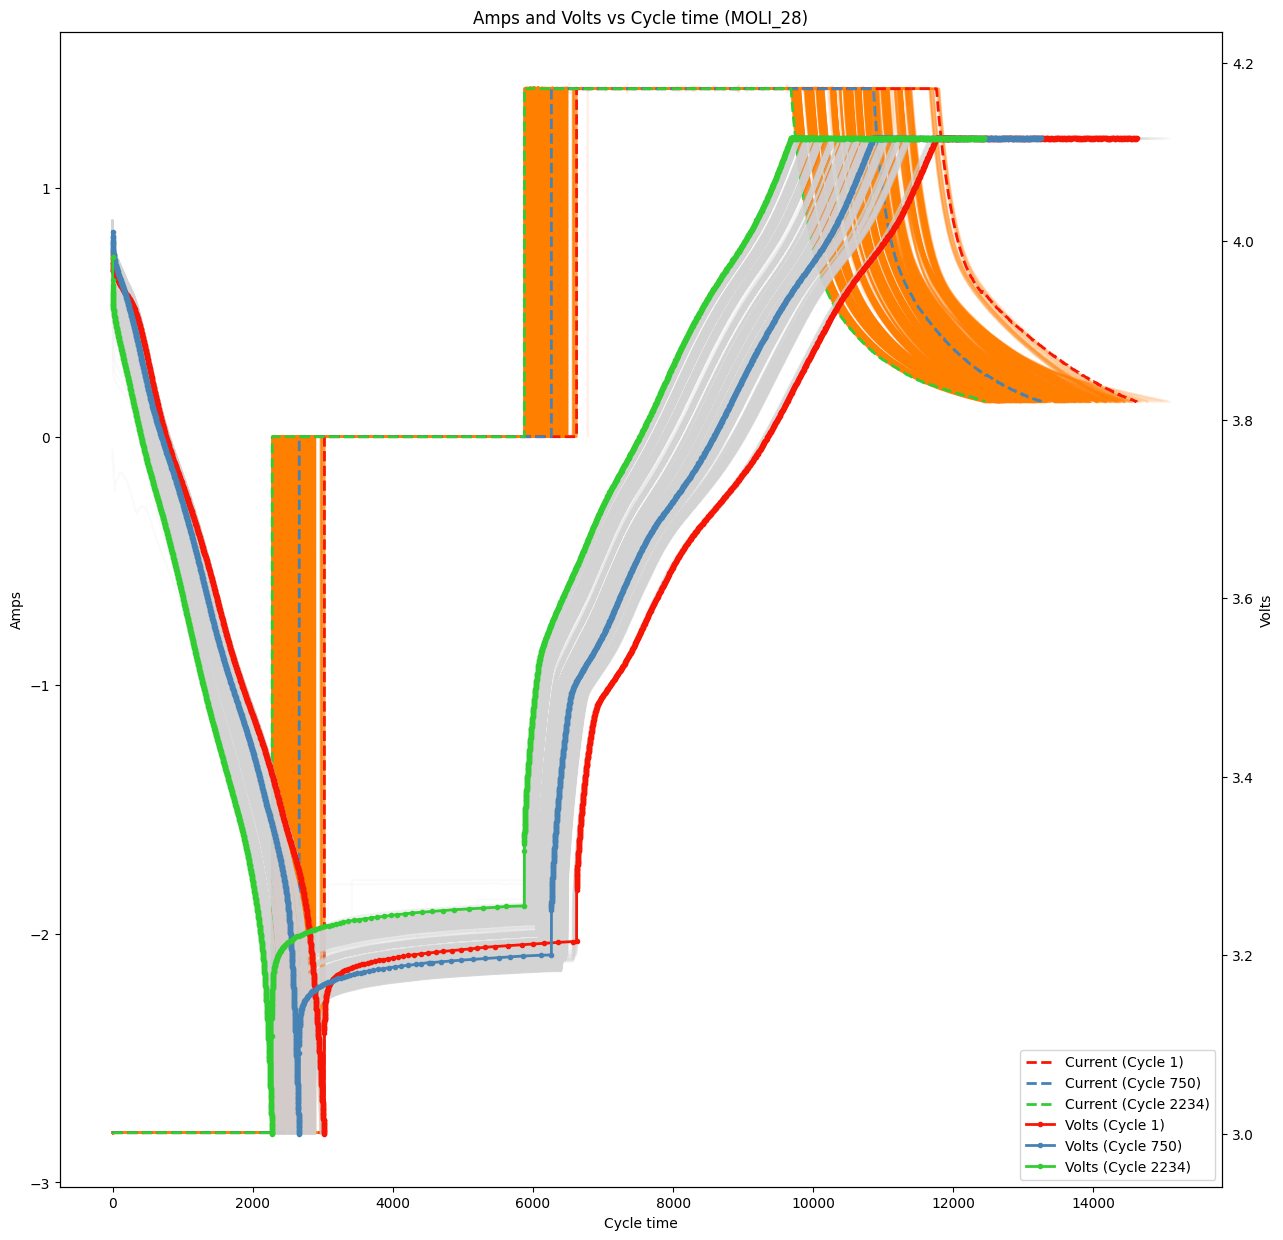

In [5]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15, 15))
ax2 = ax.twinx()

highlight_colors = {1: '#f71505', 750: '#4682B4', Auto['Cyc#'].max(): '#32CD32'}
default_color = '#D3D3D3'
volt_color = '#FF7F00'

# Group once (fast)
groups = Auto.groupby('Cyc#')

# --- Plot non-highlighted cycles (faint) ---
for cyc, data in groups:
    if cyc in highlight_colors:
        continue
    ax.plot(data['TestTime'], data['Amps'], color=volt_color, alpha=0.1)
    ax2.plot(data['TestTime'], data['Volts'], color=default_color, alpha=0.1)

# --- Plot highlighted cycles ---
for cyc, color in highlight_colors.items():
    data = groups.get_group(cyc)
    ax.plot(data['TestTime'], data['Amps'], '--', color=color, alpha=1, linewidth=2, label=f'Current (Cycle {cyc})')
    ax2.plot(data['TestTime'], data['Volts'], '.-', color=color, alpha=1, linewidth=2, label=f'Volts (Cycle {cyc})')

# --- Labels and legend ---
ax.set_xlabel('Cycle time')
ax.set_ylabel('Amps')
ax2.set_ylabel('Volts')

lines1, labels1 = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax.legend(lines1 + lines2, labels1 + labels2, loc='lower right')

plt.title('Amps and Volts vs Cycle time (MOLI_28)')
plt.show()


In [ ]:
import os
from scipy.io import savemat
# Create export directory
export_dir = "cycle_exports"
os.makedirs(export_dir, exist_ok=True)

# Choose cycle interval (every 100th)
cycle_interval = 100

# Loop over every 100th cycle
for cyc, data in Auto.groupby('Cyc#'):
    if cyc % cycle_interval == 0 or cyc in [1, Auto['Cyc#'].max()]:  # also include first and last
        export_path = os.path.join(export_dir, f"cycle_{cyc}.csv")
        mdict = {'tt': data['TestTime'].to_numpy().reshape(-1,1), 'u1': data['Amps'].to_numpy().reshape(-1,1), 'y': data['Volts'].to_numpy().reshape(-1,1)}
        savemat(os.path.join(export_dir, f"cycle_{cyc}.mat"), mdict)
        data[['TestTime', 'Amps', 'Volts']].to_csv(export_path, index=False)

print(f"✅ Exported cycles every {cycle_interval} to '{export_dir}/'")


✅ Exported cycles every 100 to 'cycle_exports/'


In [ ]:
fig.savefig('MOLI_28_VC.png', dpi=400);



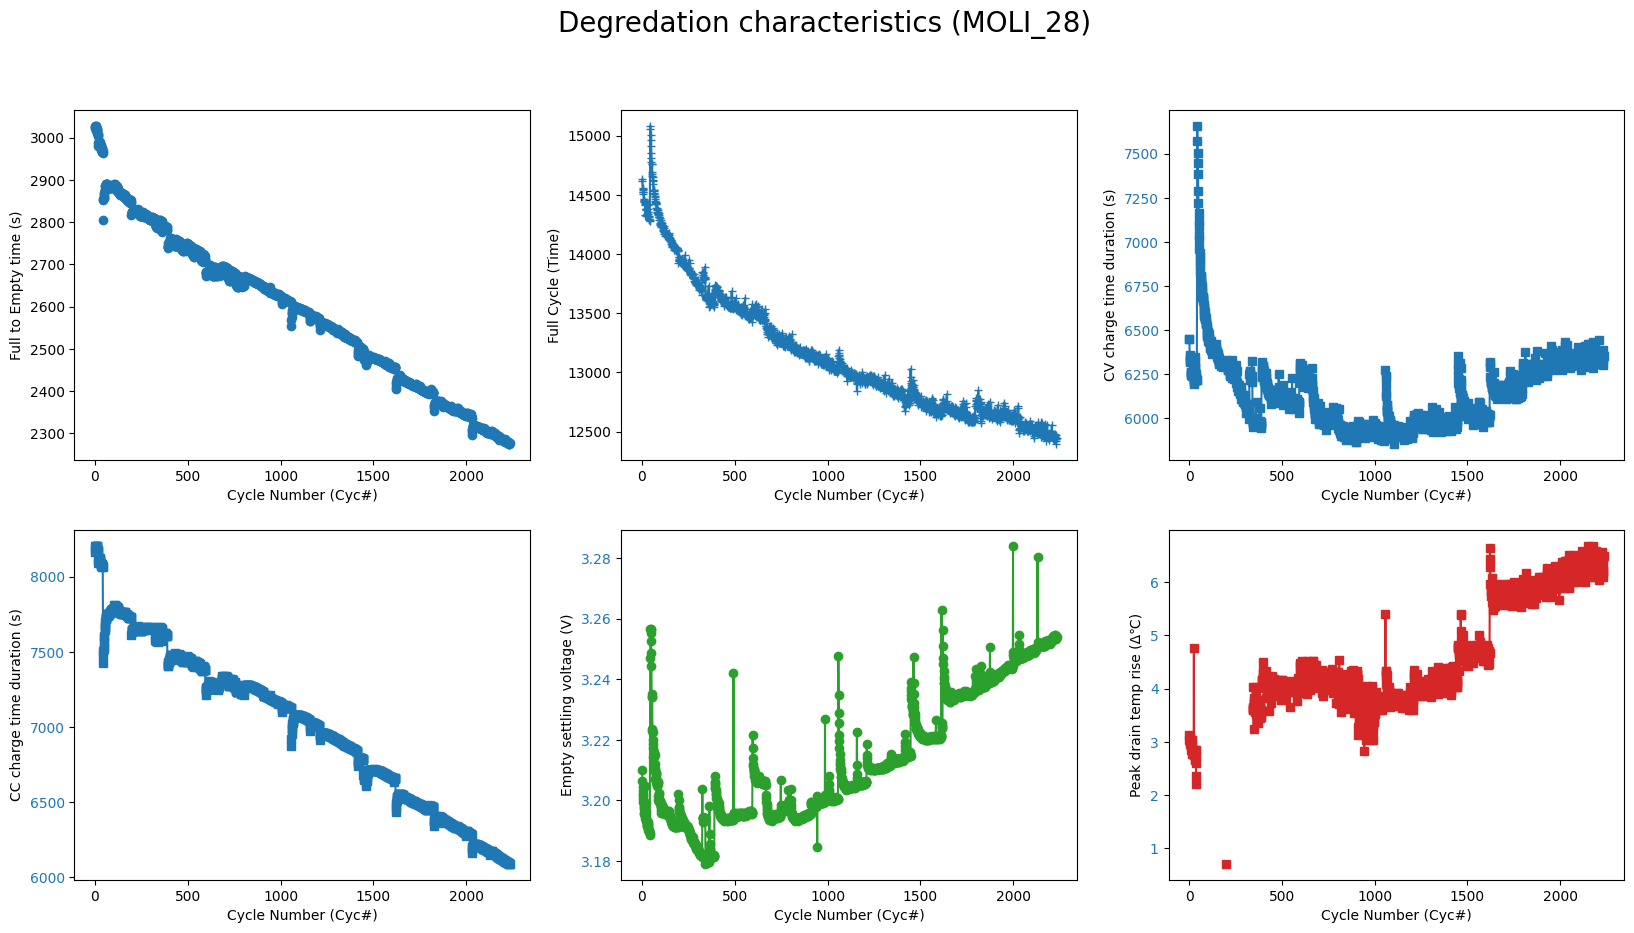

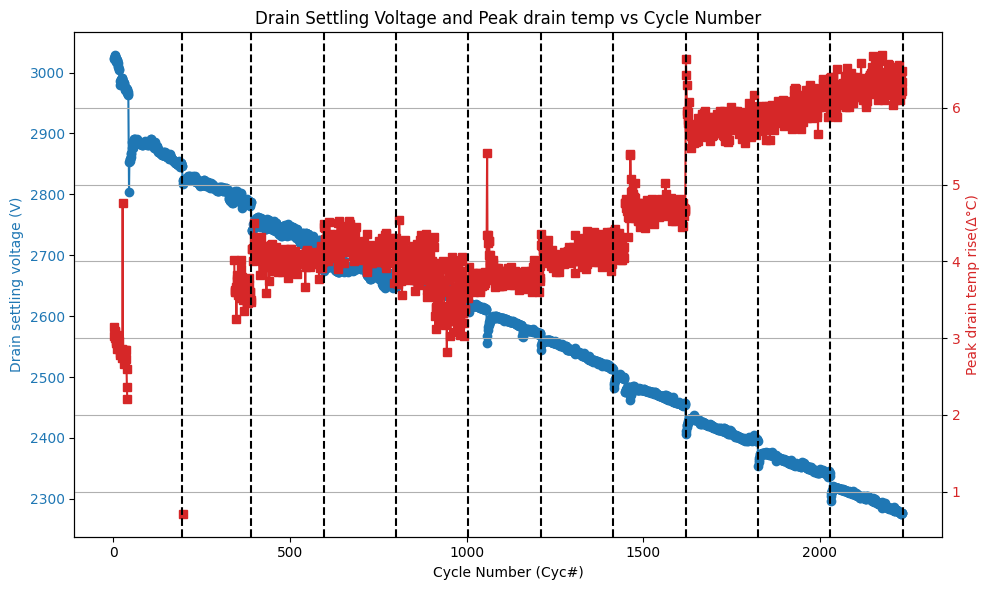

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt



# list to store (cycle, voltage, temperature)
vals_at_5500 = []

for cyc, group in Auto.groupby('Cyc#'):
    # find the index where TestTime is closest to 5500
    idx = (group['TestTime'] - 5500).abs().idxmin()
    v = group.loc[idx, 'Volts']
    t = group.loc[group['TestTime'] < 6000, 'Temp 1'].max()
    time = group['TestTime'].max()
    drain_time = group.loc[group['Volts'].idxmin(), 'TestTime']
    amp_max = group['Amps'].max()
    cross_idx = group[group['Amps'] >= 0.98 * amp_max].index[0]
    settle_time = group.loc[cross_idx, 'TestTime'] - drain_time
    cross_idx_min = group[group['Amps'] >= 0.98 * amp_max].index[-1]
    cc_time = group.loc[cross_idx_min, 'TestTime'] - settle_time
    cv_time = time - cc_time
    vals_at_5500.append((cyc, v, t, drain_time, time, settle_time, cc_time, cv_time))
  #  print(f"Cyc: {cyc}, v: {v}, drain time = {drain_time} settle_time = {settle_time}, cc_time = {cc_time}, cv_time = {cv_time}")

# convert to DataFrame for plotting
vals_df = pd.DataFrame(vals_at_5500, columns=['Cyc#', 'Voltage_at_5500', 'Temp1_at_5500','Drain Time', 'Cycle_time', 'settle_time', 'cc_time', 'cv_time'])


tup = plt.subplots(nrows=2, ncols=3, figsize=(20,10))
tup[0].suptitle('Degredation characteristics (MOLI_28)', fontsize=20)
ax = tup[1]
fig = tup[0]
color1 = 'tab:blue'
color2 = 'tab:red'
color3= 'tab:green'
tup[1][0,0].plot(vals_df['Cyc#'],vals_df['Drain Time'],'o')
ax[0,0].set_xlabel('Cycle Number (Cyc#)')
ax[0,0].set_ylabel(u'Full to Empty time (s)')
tup[1][0,1].plot(vals_df['Cyc#'],vals_df['Cycle_time'],color=color1, marker='+')
ax[0,1].set_xlabel('Cycle Number (Cyc#)')
ax[0,1].set_ylabel('Full Cycle (Time)')
ax[1,1].set_xlabel('Cycle Number (Cyc#)')
ax[1,1].set_ylabel('Empty settling voltage (V)')
ax[1,1].plot(vals_df['Cyc#'], vals_df['Voltage_at_5500'], color=color3, marker='o', label='Voltage')
ax[1,1].tick_params(axis='y', labelcolor=color1)

ax[1,0].set_xlabel('Cycle Number (Cyc#)')
ax[1,0].set_ylabel(u'CC charge time duration (s)')
ax[1,0].plot(vals_df['Cyc#'], vals_df['cc_time'], color=color1, marker='s')
ax[1,0].tick_params(axis='y', labelcolor=color1)
ax[0,2].set_xlabel('Cycle Number (Cyc#)')
ax[0,2].set_ylabel(u'CV charge time duration (s)')
ax[0,2].plot(vals_df['Cyc#'], vals_df['cv_time'], color=color1, marker='s')
ax[0,2].tick_params(axis='y', labelcolor=color1)
ax[1,2].set_xlabel('Cycle Number (Cyc#)')
ax[1,2].set_ylabel(u'Peak drain temp rise (Δ℃)')
ax[1,2].plot(vals_df['Cyc#'], vals_df['Temp1_at_5500'], color=color2, marker='s')
ax[1,2].tick_params(axis='y', labelcolor=color1)

plt.show()
fig.savefig('MOLI_28_Cycle_Feautres.png', dpi=400);
# --- Plot both on separate y-axes ---
fig, ax1 = plt.subplots(figsize=(10, 6))
color1 = 'tab:blue'
ax1.set_xlabel('Cycle Number (Cyc#)')
ax1.set_ylabel('Drain settling voltage (V)', color=color1)
ax1.plot(vals_df['Cyc#'], vals_df['Drain Time'], color=color1, marker='o', label='Voltage')
ax1.tick_params(axis='y', labelcolor=color1)

ax2 = ax1.twinx()
color2 = 'tab:red'
ax2.set_ylabel('Peak drain temp rise(Δ°C)', color=color2)
ax2.plot(vals_df['Cyc#'], vals_df['Temp1_at_5500'], color=color2, marker='s', label='Temperature')
ax2.tick_params(axis='y', labelcolor=color2)
for i in file_boundary:
  plt.axvline(int(i), color='k', linestyle='--', label='')
# Titles and grid
plt.title('Drain Settling Voltage and Peak drain temp vs Cycle Number')
fig.tight_layout()
plt.grid(True)
plt.show()
fig.savefig('MOLI_28_Cycle_Boundary.png', dpi=400);


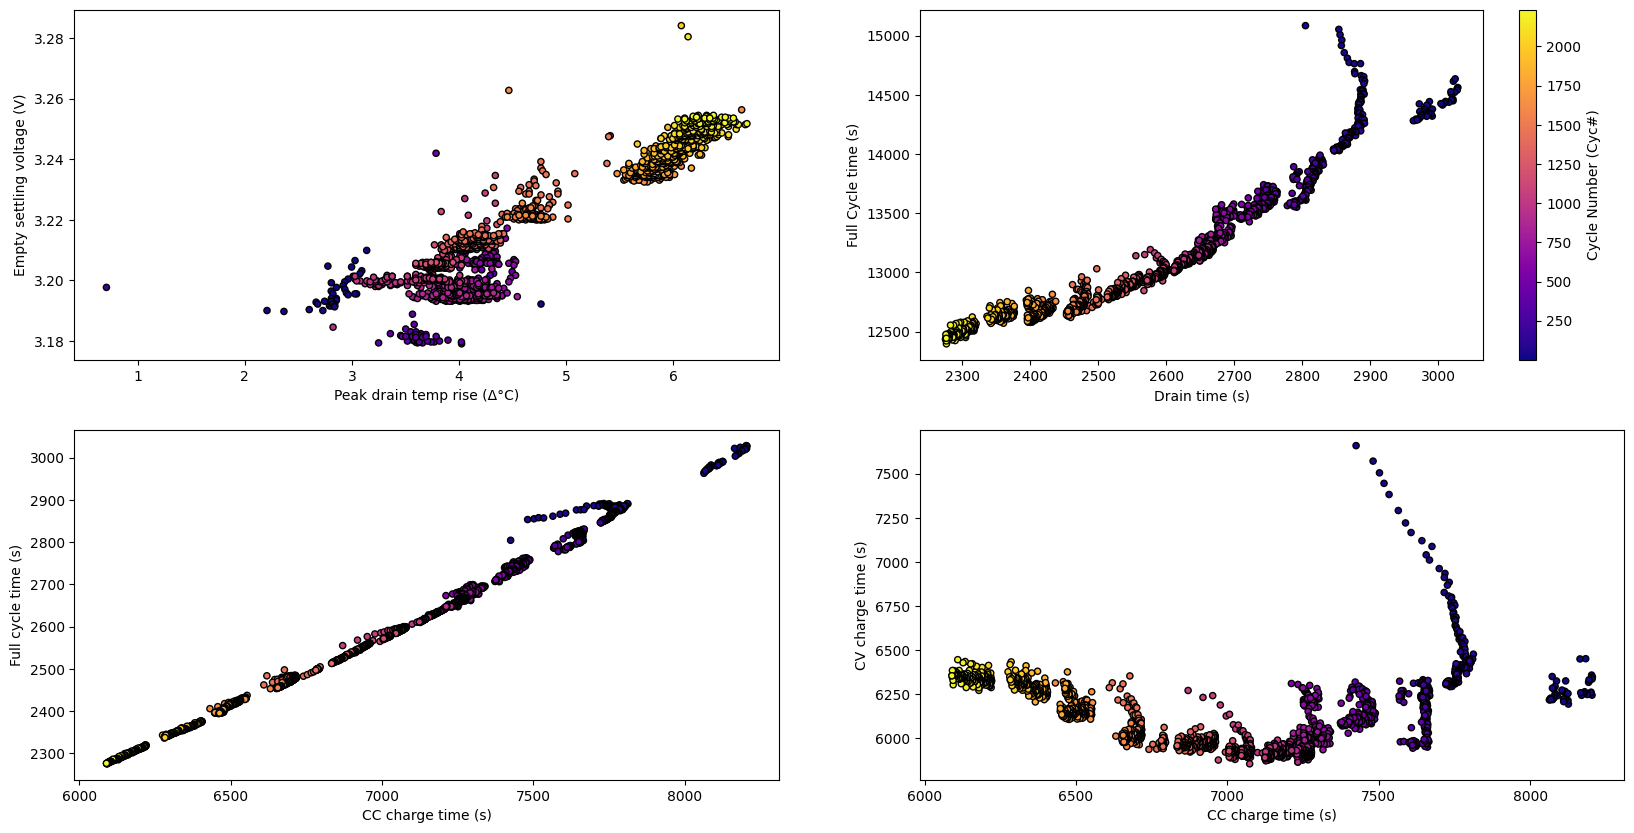

In [ ]:
import matplotlib.pyplot as plt
import matplotlib as mpl




tup = plt.subplots(nrows=2, ncols=2, figsize=(20,10))
ax = tup[1]
ax1 = ax[0,0]
fig = tup[0]
norm = mpl.colors.Normalize(vmin=vals_df['Cyc#'].min(), vmax=vals_df['Cyc#'].max())
cmap = plt.colormaps['plasma']
scatter = ax1.scatter(
    vals_df['Temp1_at_5500'],
    vals_df['Voltage_at_5500'],
    c=vals_df['Cyc#'],
    cmap=cmap,
    norm=norm,
    s=20,
    edgecolors='k'
)
cbar = plt.colorbar(scatter, ax=[tup[1][0,1]])
cbar.set_label('Cycle Number (Cyc#)')
ax1.set_xlabel(u'Peak drain temp rise (Δ°C)')
ax1.set_ylabel('Empty settling voltage (V)')

scatter2 = tup[1][0,1].scatter(
    vals_df['Drain Time'],
    vals_df['Cycle_time'],
    c=vals_df['Cyc#'],
    cmap=cmap,
    norm=norm,
    s=20,
    edgecolors='k'
)
ax[0,1].set_xlabel('Drain time (s)')
ax[0,1].set_ylabel('Full Cycle time (s)')

scatter3 = tup[1][1,1].scatter(
    vals_df['cc_time'],
    vals_df['cv_time'],
    c=vals_df['Cyc#'],
    cmap=cmap,
    norm=norm,
    s=20,
    edgecolors='k'
)
ax[1,1].set_xlabel('CC charge time (s)')
ax[1,1].set_ylabel('CV charge time (s)')

scatter4 = tup[1][1,0].scatter(
    vals_df['cc_time'],
    vals_df['Drain Time'],
    c=vals_df['Cyc#'],
    cmap=cmap,
    norm=norm,
    s=20,
    edgecolors='k'
)
ax[1,0].set_xlabel('CC charge time (s)')
ax[1,0].set_ylabel('Full cycle time (s)')


plt.show()
fig.savefig('MOLI_28_Cycle_Corr.png', dpi=400);
